# LLM-as-a-judge

## Variable Definitions

In [1]:
import pandas as pd
import os
from tqdm import tqdm
tqdm.pandas()

from src.generate import load_llama, simple_call_llama
from src.data import files_to_df, read_document


N_EXPECTED_SAMPLES = 35

model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--prometheus-eval--prometheus-7b-v2.0/snapshots/66ffb1fc20beebfb60a3964a957d9011723116c5"
source_path = "output/samples/en/phase_2/"
prompts_path = "utils/prompts"

path_gen = os.path.join(source_path, "generated")
path_orig = os.path.join(source_path, "original")
path_human = os.path.join(source_path, "human_eval.csv")
path_auto = os.path.join(source_path, "auto_eval.csv")

path_guidelines = os.path.join(prompts_path, "guidelines.txt")
guidelines = open(path_guidelines, "r").read()

assert os.path.exists(path_gen), f"Path {path_gen} does not exist"
assert os.path.exists(path_orig), f"Path {path_orig} does not exist"
assert os.path.exists(path_human), f"Path {path_human} does not exist"
assert os.path.exists(path_auto), f"Path {path_auto} does not exist"
assert os.path.exists(path_guidelines), f"Path {path_guidelines} does not exist"

## Load Data

### Clinical cases and Discharge summaries

35 Different pairs of clinical cases and discharge summaries are provided.

In the moment of writing this notebook, only 5 + 10 pairs have been annotated manually by one of our team members. The rest of the pairs are still pending to be annotated.

In [2]:
## Load and preprocess generated samples
df_pairs_gen = files_to_df(path_gen)
df_pairs_gen["filenameid"] = df_pairs_gen["filenameid"].str.replace("_transformed_step1", "")

## Load and preprocess original samples
df_pairs_orig = files_to_df(path_orig)

df_pairs = df_pairs_orig.merge(df_pairs_gen, on="filenameid", suffixes=("_orig", "_gen"))

assert len(df_pairs) == N_EXPECTED_SAMPLES, f"Expected {N_EXPECTED_SAMPLES} samples, got {len(df_pairs)}"

df_pairs = df_pairs.rename(columns={"text_orig": "clinical_case", "text_gen": "discharge_summary"})
df_pairs.head()

,filenameid,clinical_case,discharge_summary
0,32153696,An 80-year-old man who worked as a constructio...,**Discharge Summary**\n\n**Patient Information...
1,32470561,A 46-years-old female was admitted to our depa...,**Discharge Summary**\n\n**Patient Information...
2,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...
3,38422307,A 43-year-old female patient with uterine diff...,**Discharge Summary**\n\n**Patient Information...
4,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...


In [ ]:
print(df_pairs.shape)

(35, 3)


### Human Evaluation

In [ ]:
df_human = pd.read_csv(path_human)

d_score_cols = {
                        "Overall validation [Content Relevance]": "Content Relevance",
                        "Overall validation [Information Completeness]": "Information Completeness",
                        "Overall validation [Clarity and Structure]": "Clarity and Structure",
                        "Overall validation [Content Accuracy]": "Content Accuracy",
                        "Overall validation [Hallucinations]": "Hallucinations",
                        "Overall validation [Impact of Hallucinations]": "Impact of Hallucinations",
                        "Overall validation [Relevance to Practice]": "Relevance to Practice",
                        "Overall validation [Overall Quality]": "Overall Quality",
                        "Positive highlights: Describe what aspects of the synthetic discharge summaries resemble the best real EHRs? (Empty if nothing remarkable)": "Positive highlights",
                        "Negative highlights: Which aspects of the synthetic discharge summaries do not resemble well real EHRs? (Empty if nothing remarkable)": "Negative highlights",
                        "Other Comments: Do you have any other feedback or comment on the generated synthetic discharge summaries or in the original cases? (Empty if nothing remarkable)": "Other Comments"
}

df_human.rename(columns=d_score_cols, inplace=True)
df_human.rename(columns={"Original file name (e.g. 36951253)": "filenameid"}, inplace=True)

columns_to_exclude = [
    "Email Address", "Timestamp"
]
df_human = df_human.drop(columns=columns_to_exclude)
df_human = df_human.fillna("")

df_human_prompt = df_human[["filenameid"]].copy()
df_human_prompt["human_score"] = ""
df_human_prompt.loc[:, "human_score"] = df_human.iloc[:, 1:].apply(lambda x: x.to_dict(), axis=1)

df_human_prompt.head()

,filenameid,human_score
0,33857916,"{'Content Relevance': 1, 'Information Complete..."
1,34530632,"{'Content Relevance': 5, 'Information Complete..."
2,32997782,"{'Content Relevance': 4, 'Information Complete..."
3,31378248,"{'Content Relevance': 5, 'Information Complete..."
4,30785587,"{'Content Relevance': 1, 'Information Complete..."


The amount of cases annotated by the human evaluators is 15 and they contain the following information:

- `filenameid`: The name of the file
- `human_score`: A dictionary with scores associated to
  - **Content Relevance**: Does the summary focus on clinically relevant information
  - **Information Completeness**: Does the summary include all key details (diagnoses, treatments, follow-ups)?
  - **Clarity and Structure**: Is the information presented in a clear and logically structured manner like a real discharge report?
  - **Content Accuracy**: Does the report accurately reflect the clinical information provided in the input?
  - **Hallucinations**: Are there any factual inaccuracies or fabricated content in the summary?
  - **Impact of Hallucinations**: How severe are these hallucination (e.g. 1-2: Irrelevant content, 3: include details about the patients not in original, 4-5: medication doses, procedures, etc)
  - **Relevance to Practice**: Would this summary be usable in clinical practice without significant revision?
  - **Overall Quality**: How would you rate the overall quality of the discharge summary?
  
  - Free text features to be commented in error analysis. Not mandatory but open to express as much or as few as wanted.
        - **Positive/Negative highlights of generation process**
        - **Other comments on Generated/Original data sources**

In [ ]:
df_human_prompt["human_score"][0]

{'Content Relevance': 1,
 'Information Completeness': 1,
 'Clarity and Structure': 4,
 'Content Accuracy': 2,
 'Hallucinations': 1,
 'Impact of Hallucinations': 1,
 'Relevance to Practice': 1,
 'Overall Quality': 2,
 'Positive highlights': 'Good structure. ',
 'Negative highlights': 'Lack of information related with clinical course and outcome. Patient evoluciton is not completly well explained. These parts are important in this case.',
 'Other Comments': ''}

In [ ]:
print(df_human_prompt.shape)

(15, 2)


### Automatic Evaluation

Apart from human evaluation, we have also performed automatic evaluation about medical concepts coverage by applying named entity recognition (NER) and Entity Linking to UMLS to the clinical cases and discharge summaries.

The automatic evaluation is based on the following metrics:
- **precision**: The number of entities in the generated text that are correctly identified by the model divided by the total number of entities in the generated text.
- **recall**: The number of entities in the generated text that are correctly identified by the model divided by the total number of entities in the reference text.
- **f1**: The harmonic mean of precision and recall.

This automatic evaluation was performed over all the cases (1000 in total) and the results are stored in the `output/samples/en/phase_2/auto_eval.csv` file.

In [ ]:
df_auto = pd.read_csv(path_auto).drop(columns=["cluster"])
df_auto.rename(columns={"filename": "filenameid"}, inplace=True)

df_auto_prompt = df_auto[["filenameid"]].copy()
df_auto_prompt["auto_score"] = ""
df_auto_prompt.loc[:, "auto_score"] = df_auto.iloc[:, 1:].apply(lambda x: x.to_dict(), axis=1)

df_auto_prompt.head()

,filenameid,auto_score
0,32153696,"{'precision': 0.8181817438016598, 'recall': 0...."
1,32111713,"{'precision': 0.8235293875432533, 'recall': 0...."
2,31912911_1,"{'precision': 0.4999999642857168, 'recall': 0...."
3,34962277,"{'precision': 0.9999999285714336, 'recall': 0...."
4,34118375,"{'precision': 0.9499999525000024, 'recall': 0...."


In [ ]:
print(df_auto_prompt.shape)

(35, 2)


### Combination

This dataset contains all the information about the clinical cases, discharge summaries, human evaluation and automatic evaluation.

**Caution**: As the filename id is one of the fields they have to introduce, it is possible that it's wrong. We hace to check it or modify the form making them select the file from a list.

In [9]:
# model = load_llama(model_id)
df_human_prompt["filenameid"] = df_human["filenameid"].astype(str)
df_auto_prompt["filenameid"] = df_auto["filenameid"].astype(str)
df_pairs["filenameid"] = df_pairs["filenameid"].astype(str)

df_prompt = df_pairs.merge(df_human_prompt, on="filenameid").merge(df_auto_prompt, on="filenameid", how="inner")
df_prompt.head()

,filenameid,clinical_case,discharge_summary,human_score,auto_score
0,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.8666666088888928, 'recall': 0...."
1,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.3333333055555579, 'recall': 0...."
2,30072860_2,A 72-year-old man with a history of hypertensi...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.6666666222222252, 'recall': 0...."
3,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.9189188940832732, 'recall': 0...."
4,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.8275861783590973, 'recall': 0...."


In [10]:
df_prompt.shape

(15, 5)

# Prompt

One of the models that will be used to evaluate the quality of the discharge summaries is the LLM-as-a-judge fine-tuned model [Prometheus 2B](https://huggingface.co/prometheus-eval/prometheus-7b-v2.0). 



<img src="../../img/external_figures/prometheus_2_7B_finegrained_eval.JPG" alt="Prometheus Evaluation" width="700px">

In [11]:
from fastchat.conversation import get_conv_template

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [12]:
# Absolute Grading: Outputs score of 1 to 5

from prometheus_eval.vllm import VLLM
from prometheus_eval import PrometheusEval
from prometheus_eval.prompts import ABSOLUTE_PROMPT, SCORE_RUBRIC_TEMPLATE
model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--prometheus-eval--prometheus-7b-v2.0/snapshots/66ffb1fc20beebfb60a3964a957d9011723116c5"

model = VLLM(model=model_id)
judge = PrometheusEval(model=model, absolute_grade_template=ABSOLUTE_PROMPT)


INFO 03-30 17:24:34 __init__.py:207] Automatically detected platform cuda.
INFO 03-30 17:24:42 config.py:549] This model supports multiple tasks: {'embed', 'generate', 'score', 'reward', 'classify'}. Defaulting to 'generate'.
INFO 03-30 17:24:42 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/gpfs/projects/bsc14/abecerr1/hub/models--prometheus-eval--prometheus-7b-v2.0/snapshots/66ffb1fc20beebfb60a3964a957d9011723116c5', speculative_config=None, tokenizer='/gpfs/projects/bsc14/abecerr1/hub/models--prometheus-eval--prometheus-7b-v2.0/snapshots/66ffb1fc20beebfb60a3964a957d9011723116c5', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  dev

/gpfs/projects/bsc14/scratch/.conda/msds/lib/python3.11/site-packages/vllm/executor/uniproc_executor.py:29: UserWarning: Failed to get the IP address, using 0.0.0.0 by default.The value can be set by the environment variable VLLM_HOST_IP or HOST_IP.
  get_ip(), get_open_port())


INFO 03-30 17:24:43 cuda.py:229] Using Flash Attention backend.
INFO 03-30 17:24:44 model_runner.py:1110] Starting to load model /gpfs/projects/bsc14/abecerr1/hub/models--prometheus-eval--prometheus-7b-v2.0/snapshots/66ffb1fc20beebfb60a3964a957d9011723116c5...


Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]


INFO 03-30 17:24:59 model_runner.py:1115] Loading model weights took 13.4967 GB
INFO 03-30 17:25:01 worker.py:267] Memory profiling takes 1.31 seconds
INFO 03-30 17:25:01 worker.py:267] the current vLLM instance can use total_gpu_memory (63.43GiB) x gpu_memory_utilization (0.90) = 57.09GiB
INFO 03-30 17:25:01 worker.py:267] model weights take 13.50GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 3.41GiB; the rest of the memory reserved for KV Cache is 40.03GiB.
INFO 03-30 17:25:01 executor_base.py:111] # cuda blocks: 20495, # CPU blocks: 2048
INFO 03-30 17:25:01 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 10.01x
INFO 03-30 17:25:03 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory

Capturing CUDA graph shapes: 100%|███████████████████████████████████████████████████████████████████████████| 35/35 [00:11<00:00,  2.94it/s]

INFO 03-30 17:25:15 model_runner.py:1562] Graph capturing finished in 12 secs, took 0.96 GiB
INFO 03-30 17:25:15 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 15.17 seconds


In [12]:
print(ABSOLUTE_PROMPT)

###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: "(write a feedback for criteria) [RESULT] (an integer number between 1 and 5)"
4. Please do not generate any other opening, closing, and explanations.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
{rubric}

###Feedback: 


In [11]:
from prometheus_eval.prompts import ABSOLUTE_PROMPT, SCORE_RUBRIC_TEMPLATE

rubric_data = {
  "criteria":"Is the model proficient in applying empathy and emotional intelligence to its responses when the user conveys emotions or faces challenging circumstances?",
  "score1_description":"The model neglects to identify or react to the emotional tone of user inputs, giving responses that are unfitting or emotionally insensitive.",
  "score2_description":"The model intermittently acknowledges emotional context but often responds without sufficient empathy or emotional understanding.",
  "score3_description":"The model typically identifies emotional context and attempts to answer with empathy, yet the responses might sometimes miss the point or lack emotional profundity.",
  "score4_description":"The model consistently identifies and reacts suitably to emotional context, providing empathetic responses. Nonetheless, there may still be sporadic oversights or deficiencies in emotional depth.",
  "score5_description":"The model excels in identifying emotional context and persistently offers empathetic, emotionally aware responses that demonstrate a profound comprehension of the user's emotions or situation."
}

score_rubric = SCORE_RUBRIC_TEMPLATE.format(**rubric_data)
print(score_rubric)

[Is the model proficient in applying empathy and emotional intelligence to its responses when the user conveys emotions or faces challenging circumstances?]
Score 1: The model neglects to identify or react to the emotional tone of user inputs, giving responses that are unfitting or emotionally insensitive.
Score 2: The model intermittently acknowledges emotional context but often responds without sufficient empathy or emotional understanding.
Score 3: The model typically identifies emotional context and attempts to answer with empathy, yet the responses might sometimes miss the point or lack emotional profundity.
Score 4: The model consistently identifies and reacts suitably to emotional context, providing empathetic responses. Nonetheless, there may still be sporadic oversights or deficiencies in emotional depth.
Score 5: The model excels in identifying emotional context and persistently offers empathetic, emotionally aware responses that demonstrate a profound comprehension of the us

In [10]:

instruction = "Struggling with a recent break-up, a person opens up about the intense feelings of loneliness and sadness. They ask for advice on how to cope with the heartbreak and move forward in life.",
response = "I'm genuinely sorry to hear about your break-up. This can be an immensely challenging time filled with intense emotions of loneliness and sorrow. It's important to remember that it's normal to experience these feelings; they are a testament to the deep connection you once had. Firstly, don't hesitate to embrace your emotions, let them flow freely. Ignoring them often complicates the healing process. It's natural to be upset, to shed tears, or to feel angry. This is all part of the journey towards healing. Self-care can be a healing balm in these tough times. This could mean indulging in your favourite book, journaling your thoughts, or even just a quiet cup of tea. Small acts of kindness to oneself can significantly improve your emotional well-being. Also, don't isolate yourself. Surround yourself with supportive individuals who can offer comfort and understanding. This might include friends, family, or even a mental health professional. They can provide much-needed emotional support and strategies to help you cope. Lastly, remember there's no set timeline for healing. It's different for everyone and it's okay to take as long as you need. Keep your focus on the future and the potential it holds. Though it may not seem possible now, you will emerge stronger from this experience. It's okay to ask for help, it's okay to grieve, and it's okay to take it one day at a time. You're not alone in this journey, and there are people ready and willing to help. It's okay to heal at your own pace.",
reference_answer = "I can only imagine how difficult this time must be for you. Heartbreak can feel like an overwhelming wave that washes over you, making you feel lost and alone. It's important to remember that it's okay to feel this way; your feelings are valid and it's natural to grieve the loss of a relationship. Firstly, it's crucial to allow yourself to feel the emotions fully. Suppressing or denying them often only prolongs the healing process. It's okay to cry, to feel sad, or to be angry. These are all part of the healing journey. Engaging in self-care activities can also provide a much-needed boost. This could be anything from taking a warm bath, writing in a journal, or simply drinking a cup of your favorite tea. Small acts of self-love can make a big difference in how you feel. Next, try to surround yourself with supportive people who understand your situation and provide comfort. Friends and family can be a great source of strength in times of heartbreak. If you feel comfortable, you might want to consider seeking professional help. Therapists and counselors are trained to provide assistance and tools to navigate through difficult times like these. Lastly, it's important to remember that it's okay to take your time to heal. Everyone has their own pace and there's no rush. Try to focus on the future and the possibilities it holds. While it may not seem like it now, you will come out stronger and more resilient from this experience. Remember, it's okay to ask for help and it's okay to feel the way you feel. You are not alone in this journey and there are people who care about you and want to help. It's okay to take one day at a time. Healing is a process, and it's okay to move through it at your own pace.",

rubric_data = {
  "criteria":"Is the model proficient in applying empathy and emotional intelligence to its responses when the user conveys emotions or faces challenging circumstances?",
  "score1_description":"The model neglects to identify or react to the emotional tone of user inputs, giving responses that are unfitting or emotionally insensitive.",
  "score2_description":"The model intermittently acknowledges emotional context but often responds without sufficient empathy or emotional understanding.",
  "score3_description":"The model typically identifies emotional context and attempts to answer with empathy, yet the responses might sometimes miss the point or lack emotional profundity.",
  "score4_description":"The model consistently identifies and reacts suitably to emotional context, providing empathetic responses. Nonetheless, there may still be sporadic oversights or deficiencies in emotional depth.",
  "score5_description":"The model excels in identifying emotional context and persistently offers empathetic, emotionally aware responses that demonstrate a profound comprehension of the user's emotions or situation."
}

score_rubric = SCORE_RUBRIC_TEMPLATE.format(**rubric_data)


feedback, score = judge.single_absolute_grade(
    instruction=instruction,
    response=response,
    rubric=score_rubric,
    reference_answer=reference_answer
)

print("Feedback:", feedback)
print("Score:", score)

# Output
# Feedback: The response provided shows a high level of empathy and emotional intelligence. It effectively addresses the emotional distress expressed by the user. It acknowledges the user's pain and validates their feelings of loneliness and sadness, which is a crucial aspect of providing empathetic advice. The response also suggests practical steps for coping, such as embracing emotions, practicing self-care, and seeking support from friends, family, or professionals. Furthermore, the response reassures the user that healing is a personal process with no fixed timeline, offering comfort and understanding. It emphasizes the user's worth and potential to overcome the situation, which demonstrates a profound comprehension of the user's emotions and situation. By comparing the score rubric with the provided response, it is clear that the model exhibits an excellent ability to apply empathy and emotional intelligence. The response does not have any deficiencies in emotional depth and successfully meets the criteria for a score of 5.
# Score: 5

Processed prompts:   0%|                                                                                                                     | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it, est. speed input: 400.60 toks/s, output: 80.58 toks/s]


Processed 1/1 instances.


Finalizing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Feedback: The given response shows a high level of empathy and emotional intelligence. It effectively addresses the emotional distress expressed by the user. It starts by validating the user's feelings and emphasizing that such emotions are normal, showing a clear understanding of the emotional context. The response then guides the user through a series of actions, from embracing emotions to practicing self-care, demonstrating a deep awareness of emotional healing. It encourages the user not to isolate themselves and stresses the importance of a support system. Furthermore, it underscores the unique nature of the healing process, emphasizing patience and a future-oriented perspective. It finishes by reminding the user that they are not alone and that there are people willing to help, reinforcing a sense of community and support. The response is consistent in its application of empathy and emotional intelligence throughout. It acknowledges the user's emotions and provides a thoughtful, 

In [11]:
df_prompt.iloc[2]["human_score"]

{'Content Relevance': 5,
 'Information Completeness': 5,
 'Clarity and Structure': 3,
 'Content Accuracy': 5,
 'Hallucinations': 1,
 'Impact of Hallucinations': 1,
 'Relevance to Practice': 3,
 'Overall Quality': 4,
 'Positive highlights': 'datos muy completos, estrcutura fiel al documento de origen ',
 'Negative highlights': 'La parte correspondiente a la  enfermedad actual y la evolción no está estructurado como un informe de alta',
 'Other Comments': ''}

In [14]:

instruction = """
One of the main bottlenecks for the development of clinical NLP resources if the lack of access to clinical records due to data privacy issues. This is particularly true for developments beyond English, as most of the accessible anonymized clinical record datasets are only available for this language.
To examine if clinical case report publications could potentially be considered as a data source to generate synthetic clinical discharge summaries by means of generative AI solutions, prompt instructions combined with automatic clinical were applied.
This structured summary has the purpose to systematically characterize the clinical language characteristics of synthetic discharge summaries.
Each discharge summary was assessed for a predefined set of features.
"""

# Retrieve the generated discharge summary and the corresponding clinical case from the dataframe
response = df_prompt.iloc[1]["discharge_summary"]
reference_answer = df_prompt.iloc[1]["clinical_case"]

# Likert scale evaluation rubric (ratings 1 to 5)
rubric_data = {
    "Content Relevance": {
        "criteria": "Does the summary focus on clinically relevant information?",
        "score1_description": "The summary largely misses the clinically relevant details.",
        "score2_description": "The summary includes only a few clinically relevant details.",
        "score3_description": "The summary covers some relevant information but omits key aspects.",
        "score4_description": "The summary covers most clinically relevant details with minor omissions.",
        "score5_description": "The summary is entirely focused on clinically relevant information."
    },
    "Information Completeness": {
        "criteria": "Does the summary include all key details (diagnoses, treatments, follow-ups)?",
        "score1_description": "Key details are largely missing from the summary.",
        "score2_description": "Only a few key details are present, with many important ones absent.",
        "score3_description": "Some key details are included, but several are missing.",
        "score4_description": "Most key details are present, though a few minor elements may be missing.",
        "score5_description": "The summary comprehensively includes all required key details."
    },
    "Clarity and Structure": {
        "criteria": "Is the information presented in a clear and logically structured manner like a real discharge report?",
        "score1_description": "The summary is poorly organized and very hard to follow.",
        "score2_description": "The structure is inconsistent and makes the content challenging to understand.",
        "score3_description": "The summary is moderately clear and structured, though improvements are needed.",
        "score4_description": "The summary is clear and well-organized with only minor issues.",
        "score5_description": "The summary is very clear, logically structured, and mimics a professional discharge report."
    },
    "Content Accuracy": {
        "criteria": "Does the report accurately reflect the clinical information provided in the input?",
        "score1_description": "The summary contains numerous inaccuracies compared to the input.",
        "score2_description": "The summary has several inaccuracies that affect its reliability.",
        "score3_description": "The summary is generally accurate but includes some errors.",
        "score4_description": "The summary is mostly accurate with only minor discrepancies.",
        "score5_description": "The summary accurately reflects the clinical information provided."
    },
    "Hallucinations": {
        "criteria": "Are there any factual inaccuracies or fabricated content in the summary?",
        "score1_description": "The summary is completely free of hallucinations or fabricated content.",
        "score2_description": "The summary is nearly free of hallucinations, with minimal issues.",
        "score3_description": "There are minor inaccuracies or fabricated details present.",
        "score4_description": "The summary shows noticeable inaccuracies or hallucinations.",
        "score5_description": "The summary contains significant fabricated or inaccurate content"
    },
    "Impact of Hallucinations": {
        "criteria": "How severe are the hallucinations?",
        "score1_description": "Hallucinations, if present, are minor and do not affect key details.",
        "score2_description": "Hallucinations are noticeable but do not significantly impact clinical relevance.",
        "score3_description": "Hallucinations include some extra details not present in the original.",
        "score4_description": "Hallucinations affect important clinical details moderately.",
        "score5_description": "Hallucinations are severe, impacting critical clinical information such as medication doses or procedures."
    },
    "Relevance to Practice": {
        "criteria": "Would this summary be usable in clinical practice without significant revision?",
        "score1_description": "The summary is not usable in its current form for clinical practice.",
        "score2_description": "The summary requires major revisions to be usable.",
        "score3_description": "The summary is moderately usable but needs some revisions.",
        "score4_description": "The summary is largely usable with only minor revisions needed.",
        "score5_description": "The summary is fully usable in clinical practice without significant revisions."
    },
    "Overall Quality": {
        "criteria": "How would you rate the overall quality of the discharge summary?",
        "score1_description": "The overall quality of the summary is very poor.",
        "score2_description": "The summary is below acceptable quality.",
        "score3_description": "The summary is of acceptable quality, but improvements are needed.",
        "score4_description": "The summary is of high quality, with only minor imperfections.",
        "score5_description": "The summary is excellent in overall quality."
    }
}

# These dictionaries can now be used by your LLM judge system to score and comment on the generated discharge summary.
score_rubric = SCORE_RUBRIC_TEMPLATE.format(**rubric_data["Relevance to Practice"])


# feedback, score = judge.single_absolute_grade(
#     instruction=instruction,
#     response=response,
#     rubric=score_rubric,
#     reference_answer=reference_answer
# )

# print("Feedback:", feedback)
# print("Score:", score)

# Output
# Feedback: The response provided shows a high level of empathy and emotional intelligence. It effectively addresses the emotional distress expressed by the user. It acknowledges the user's pain and validates their feelings of loneliness and sadness, which is a crucial aspect of providing empathetic advice. The response also suggests practical steps for coping, such as embracing emotions, practicing self-care, and seeking support from friends, family, or professionals. Furthermore, the response reassures the user that healing is a personal process with no fixed timeline, offering comfort and understanding. It emphasizes the user's worth and potential to overcome the situation, which demonstrates a profound comprehension of the user's emotions and situation. By comparing the score rubric with the provided response, it is clear that the model exhibits an excellent ability to apply empathy and emotional intelligence. The response does not have any deficiencies in emotional depth and successfully meets the criteria for a score of 5.
# Score: 5

In [15]:
def compute_llm_eval(row):
    instruction = row["clinical_case"]
    response = row["discharge_summary"]
    reference_answer = row["clinical_case"]

    feedbacks = {}
    scores = {}

    for col in rubric_data.keys():
        score_rubric = SCORE_RUBRIC_TEMPLATE.format(**rubric_data[col])
        feedback, score = judge.single_absolute_grade(
            instruction=instruction,
            response=response,
            rubric=score_rubric,
            reference_answer=reference_answer
        )
        feedbacks[col] = feedback
        scores[col] = score

    return pd.Series({
        "feedbacks": feedbacks,
        "scores": scores
    })

In [81]:
# df_prompt[["feedbacks", "scores"]] = df_prompt.progress_apply(compute_llm_eval, axis=1)
df_prompt = pd.read_csv("output/evaluation/prometheus-2-7B/complete_evaluation.csv")

In [82]:
df_prompt.head()

,filenameid,clinical_case,discharge_summary,human_score,auto_score,feedbacks,scores
0,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.8666666088888928, 'recall': 0....","{'Content Relevance': ""The response provided a...","{'Content Relevance': 4, 'Information Complete..."
1,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.3333333055555579, 'recall': 0....","{'Content Relevance': ""The provided discharge ...","{'Content Relevance': 4, 'Information Complete..."
2,30072860_2,A 72-year-old man with a history of hypertensi...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.6666666222222252, 'recall': 0....","{'Content Relevance': ""The response provided c...","{'Content Relevance': 4, 'Information Complete..."
3,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.9189188940832732, 'recall': 0....",{'Content Relevance': 'The response presents a...,"{'Content Relevance': 5, 'Information Complete..."
4,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.8275861783590973, 'recall': 0....","{'Content Relevance': ""The response provides a...","{'Content Relevance': 5, 'Information Complete..."


In [62]:
df_prompt.to_csv("output/evaluation/prometheus-2-7B/complete_evaluation.csv", index=False)

In [17]:
df_jud = pd.DataFrame(df_prompt["scores"].values.tolist())
# df_jud.columns = [f"{col}_judge" for col in df_jud.columns]
df_jud

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality
0,4,4,5,5,5,1,5,4
1,4,4,5,5,1,2,4,4
2,4,5,4,5,5,5,1,4
3,5,4,5,3,1,5,4,4
4,5,4,4,5,5,1,4,5
5,5,4,5,5,5,5,4,5
6,5,4,4,5,4,2,5,4
7,4,4,4,4,5,5,4,4
8,4,5,4,5,4,3,5,4
9,5,5,5,5,5,5,4,4


In [18]:
df_human_ = pd.DataFrame(df_prompt["human_score"].values.tolist())
df_human_

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other Comments
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",
1,4,3,4,4,1,1,4,4,,Se pierde mucha información sobre la explicaci...,
2,4,3,4,3,1,1,3,3,ordena muy bien los resultados de la ecografía.,Faltan los datos hemodinámicos cardiacos y pul...,
3,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,
4,5,5,4,4,1,1,4,4,,Se debería mencionar el motivo de admisión: an...,
5,5,5,4,4,1,1,4,4,Muy bien especificado Chief complaint,Se podría separar la enfermedad actual de los ...,
6,4,2,5,4,1,1,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",
7,5,5,4,5,1,1,5,5,,la razón de admisión suele ser algo más genera...,
8,5,4,5,5,1,1,5,5,,,
9,5,5,5,5,1,1,5,5,,,


In [19]:
df_human_.loc[10]["Positive highlights"]

'Highly accurate in the diagnosis.An excellent overall performance'

In [20]:
df_human_.loc[10]["Negative highlights"]

'Omited information: ECG Holter and EKG after CV (both are important in FA clinical cases)'

In [21]:
df_prompt["feedbacks"].loc[9]

{'Content Relevance': "This discharge summary effectively communicates all relevant clinical details and follows a structured and coherent format. It includes a detailed medical history, outlines the patient's presenting complaint, describes the diagnostic procedures in depth, and details the treatment process and its outcome. Additionally, it touches on the patient's follow-up, reinforcing the completeness of the information presented. This level of detail aligns with the highest standard outlined in the score rubric, ensuring all key clinical aspects have been covered. The summary also provides clear instructions for ongoing care, which is crucial in the context of postoperative care. Therefore, it can be concluded that the response is entirely focused on clinically relevant information, fulfilling the highest standards of the score rubric. \n[RESULT] 5",
 'Information Completeness': "The response accurately summarizes the medical history, procedure details, and follow-up information

In [22]:
import numpy as np
{col: np.corrcoef(df_jud[col], df_human_[col])[0, 1] for col in df_jud.columns}

/home/bsc/bsc830651/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bsc/bsc830651/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


{'Content Relevance': 0.6667668935268751,
 'Information Completeness': 0.06845462448856664,
 'Clarity and Structure': 0.32385202946145236,
 'Content Accuracy': -0.2806067666331569,
 'Hallucinations': nan,
 'Impact of Hallucinations': nan,
 'Relevance to Practice': 0.017113656122141656,
 'Overall Quality': -0.030772872744833184}

In [26]:
df_human_["filenameid"] = df_prompt["filenameid"]
df_jud["filenameid"] = df_prompt["filenameid"]

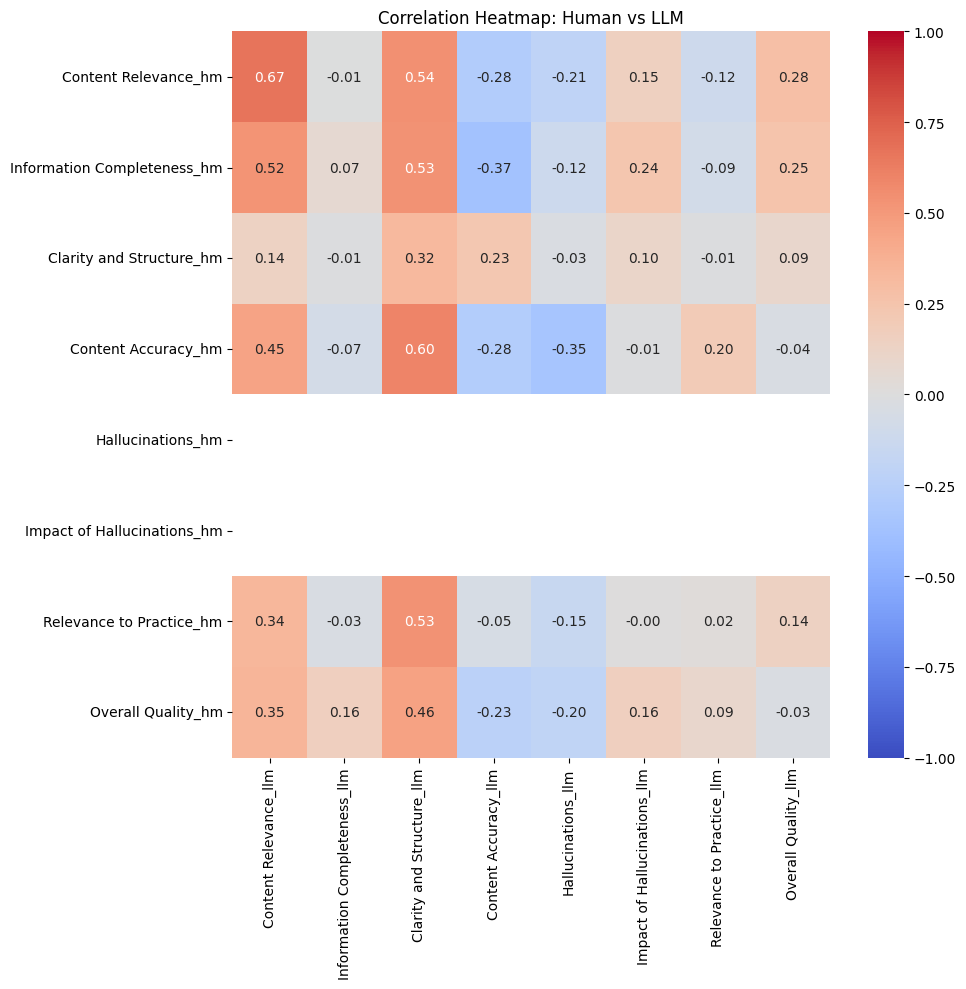

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df_hm, df_llm, suffixes=("_hm", "_llm")):
    """Plot a heatmap of correlations."""
    
    df_hm_llm_corr = df_hm.merge(df_llm, on="filenameid", suffixes=suffixes)
    df_hm_llm_corr = df_hm_llm_corr.select_dtypes(np.number).corr()
    
    fig, ax = plt.subplots(figsize=(10, 10))
    x_suffix, y_suffix = suffixes[0], suffixes[1]
    x_cols = [col for col in df_hm_llm_corr.columns if col.endswith(x_suffix)]
    y_cols = [col for col in df_hm_llm_corr.columns if col.endswith(y_suffix)]

    corr_matrix = df_hm_llm_corr.loc[x_cols, y_cols]
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, ax=ax)
    ax.set_title("Correlation Heatmap: Human vs LLM")
    fig.tight_layout()
    # plt.savefig(os.path.join(output_path, "correlation_heatmap.png"))   
    return fig , corr_matrix

fig, corr_matrix = plot_correlation_heatmap(df_human_, df_jud)

plt.savefig("output/evaluation/prometheus-2-7B/correlation_heatmap.png")

In [64]:
def get_corr_scores(df_human, df_jud):
    """Compute the correlation scores."""
    
    corr_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        corr_scores[col] = np.corrcoef(df_human[col], df_jud[col])[0, 1]
    return corr_scores

corr_scores = get_corr_scores(df_human_, df_jud)
corr_scores

/home/bsc/bsc830651/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bsc/bsc830651/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


{'Content Relevance': 0.666766893526875,
 'Information Completeness': 0.06845462448856664,
 'Clarity and Structure': 0.32385202946145236,
 'Content Accuracy': -0.280606766633157,
 'Hallucinations': nan,
 'Impact of Hallucinations': nan,
 'Relevance to Practice': 0.017113656122141656,
 'Overall Quality': -0.030772872744833184}

In [65]:
def get_mae_scores(df_human, df_jud):
    """Compute the mean absolute error scores."""
    
    mae_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        mae_scores[col] = np.mean(np.abs(df_human[col] - df_jud[col]))
    return mae_scores

mae_scores = get_mae_scores(df_human_, df_jud)
mae_scores

{'Content Relevance': 0.6,
 'Information Completeness': 1.3333333333333333,
 'Clarity and Structure': 0.6,
 'Content Accuracy': 1.1333333333333333,
 'Hallucinations': 2.8,
 'Impact of Hallucinations': 2.4,
 'Relevance to Practice': 1.2,
 'Overall Quality': 1.0}

In [68]:
from sklearn.metrics import f1_score
def get_f1_scores(df_human, df_jud):
    """Compute the F1 scores."""
    
    f1_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        f1_scores[col] = f1_score(df_human[col], df_jud[col], average="weighted")
    return f1_scores

f1_scores = get_f1_scores(df_human_, df_jud)
f1_scores

{'Content Relevance': 0.5222222222222223,
 'Information Completeness': 0.1907692307692308,
 'Clarity and Structure': 0.45454545454545453,
 'Content Accuracy': 0.20740740740740737,
 'Hallucinations': 0.3333333333333333,
 'Impact of Hallucinations': 0.4210526315789474,
 'Relevance to Practice': 0.25230769230769234,
 'Overall Quality': 0.1411764705882353}

In [69]:
df_eval = pd.DataFrame([corr_scores, mae_scores, f1_scores]).T
df_eval.columns = ["correlation", "mae", "f1"]
df_eval

,correlation,mae,f1
Content Relevance,0.666767,0.600000,0.522222
Information Completeness,0.068455,1.333333,0.190769
Clarity and Structure,0.323852,0.600000,0.454545
Content Accuracy,-0.280607,1.133333,0.207407
Hallucinations,NaN,2.800000,0.333333
Impact of Hallucinations,NaN,2.400000,0.421053
Relevance to Practice,0.017114,1.200000,0.252308
Overall Quality,-0.030773,1.000000,0.141176


In [70]:
df_eval.to_csv("output/evaluation/prometheus-2-7B/evaluation_scores.csv")

In [71]:
df_diff = (df_jud.select_dtypes(int) - df_human_.select_dtypes(int))
df_diff["filenameid"] = df_jud["filenameid"]

df_diff.select_dtypes(int).abs().mean()

Content Relevance           0.600000
Information Completeness    1.333333
Clarity and Structure       0.600000
Content Accuracy            1.133333
Hallucinations              2.800000
Impact of Hallucinations    2.400000
Relevance to Practice       1.200000
Overall Quality             1.000000
dtype: float64

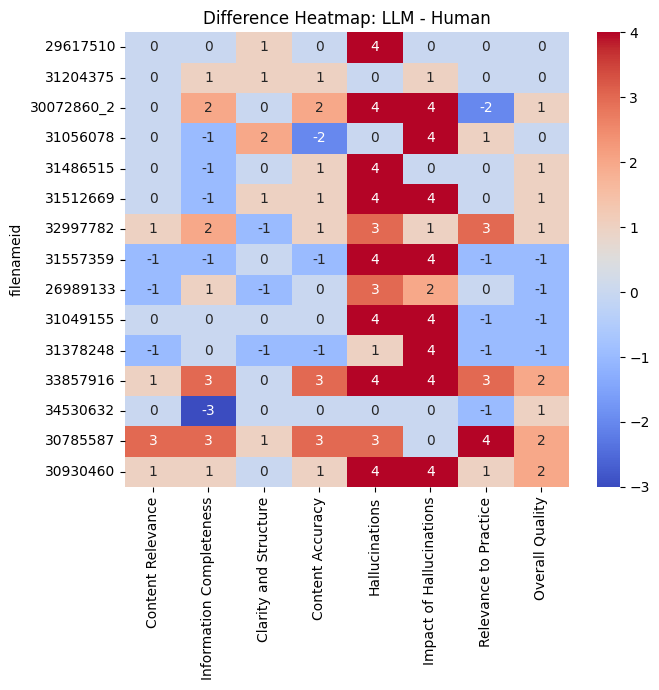

In [79]:
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.heatmap(df_diff.set_index("filenameid"), annot=True, cmap="coolwarm")
plt.title("Difference Heatmap: LLM - Human")
plt.tight_layout()
plt.savefig("output/evaluation/prometheus-2-7B/difference_heatmap.png")

In [50]:
col = "Information Completeness"
y_true = df_human_[col]
y_pred = df_jud[col]

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       0.10      0.33      0.15         3
           5       0.50      0.33      0.40         6

    accuracy                           0.20        15
   macro avg       0.12      0.13      0.11        15
weighted avg       0.22      0.20      0.19        15



In [49]:
col = "Content Relevance"
y_true = df_human_[col]
y_pred = df_jud[col]

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           4       0.43      0.60      0.50         5
           5       0.71      0.62      0.67         8

    accuracy                           0.53        15
   macro avg       0.29      0.31      0.29        15
weighted avg       0.52      0.53      0.52        15



In [57]:
df_qual_eval = df_prompt.copy()
df_qual_eval.set_index("filenameid", inplace=True)
df_fb = df_qual_eval["feedbacks"].apply(pd.Series)
print(df_fb.loc["33857916"].to_markdown())

|                          | 33857916                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [60]:
print(df_human_[df_human_["filenameid"] == "33857916"].T.to_markdown())

|                          | 11                                                                                                                                                        |
|:-------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------|
| Content Relevance        | 1                                                                                                                                                         |
| Information Completeness | 1                                                                                                                                                         |
| Clarity and Structure    | 4                                                                                                                                                         |
| Content Accuracy         | 2                                             